In [45]:
import torch
from torch import nn
from d2l import torch as d2l

In [46]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

In [ ]:
net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),  # nn.Sigmoid()改为ReLU以改善梯度流动，避免Sigmoid的梯度消失问题
    # nn.AvgPool2d(kernel_size=2, stride=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),  # 同样改为ReLU
    # nn.AvgPool2d(kernel_size=2, stride=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    # nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.LazyLinear(120), nn.ReLU(),  # 改为ReLU
    nn.Linear(120, 84), nn.ReLU(),  # 改为ReLU
    nn.Linear(84, 10)
)

In [48]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [49]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [50]:
def evaluate_accuracy(net, data_iter, device = None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
        
    return metric[0] / metric[1]

In [51]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型（在第6章中将介绍）"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失总和、训练准确率总和、样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if( i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.6f}, train acc {train_acc:.6f}, '
          f'test acc {test_acc:.6f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

loss 0.276554, train acc 0.898100, test acc 0.870700
143448.7 examples/sec on cuda:0


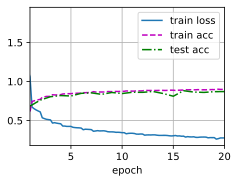

In [52]:
lr, num_epochs = 0.05, 20  # 低学习率适配ReLU, 增加epoch以获得更好收敛
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())